In [2]:
# THIS PARAMETER IS USED FOR LOOPING OVER THE NOTEBOOK IN THE "run_all_customers" NOTEBOOK
system_id = 1

In [3]:
# Base library imports
import pandas as pd
import torch
import os
from matplotlib import pyplot as plt

# SolNet imports
from src.data.datafetcher import PvFetcher
from src.data.featurisation import Featurisation
from src.tensors.tensorisation import Tensors
from src.models.lstm import LSTM
from src.models.training import Training
from src.models.training import save_model
from src.evaluation.evaluation import Evaluation

In [4]:
# Hyperparameters needed for a run:

# Data fetching
locations_used = 1
start_date = 2005
end_date = 2010

# Forecasting parameters
target = 'P'
past_features = ['P']
future_features = ['hour_sin','hour_cos']
lags = 24
forecast_period = 24
gap = 0 
forecast_gap = 0

# Lstm parameters
hidden_size = 400
num_layers = 3
dropout = 0.5
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Training parameters
epochs = 200
batch_size = 32
learning_rate = 0.0001

## 1. Target location

In [5]:
data_aus = pd.read_parquet('../data/australia/aus_production.parquet', engine='pyarrow')
data_aus = data_aus[data_aus['Customer'] == system_id]
data_aus

,Customer,Postcode,Generator Capacity,Values,latitude,longitude
date,,,,,,
2011-07-01 00:00:00,1.0,2076,3.78,0.0,-33.696992,151.13078
2011-07-01 00:30:00,1.0,2076,3.78,0.0,-33.696992,151.13078
2011-07-01 01:00:00,1.0,2076,3.78,0.0,-33.696992,151.13078
2011-07-01 01:30:00,1.0,2076,3.78,0.0,-33.696992,151.13078
2011-07-01 02:00:00,1.0,2076,3.78,0.0,-33.696992,151.13078
...,...,...,...,...,...,...
2013-06-30 21:30:00,1.0,2076,3.78,0.0,-33.696992,151.13078
2013-06-30 22:00:00,1.0,2076,3.78,0.0,-33.696992,151.13078
2013-06-30 22:30:00,1.0,2076,3.78,0.0,-33.696992,151.13078


In [6]:
# Hyperparams from the data
peak_power = data_aus['Generator Capacity'].iloc[0]
latitude = data_aus['latitude'].iloc[0]
longitude = data_aus['longitude'].iloc[0]

# Hyperparams not included in the data
tilt = 0
azimuth = 0
# The optimal angles replaces the tilt and azimuth by "ideal" settings
optimalangles = True

latitude, longitude, peak_power, tilt, azimuth

(-33.69699153381296, 151.13077966206853, 3.78, 0, 0)

In [7]:
# Unique name for the data, model and metrics
data_name = 'base_' + 'australia' '_' + str(system_id)
data_name

'base_australia_1'

In [8]:
# Create the folders to save the data and models
data_folder = '../results/AUS/'
model_folder = '../models/AUS/' + data_name
if not os.path.exists(data_folder):
    os.makedirs(data_folder)
if not os.path.exists(model_folder):
    os.makedirs(model_folder)

In [9]:
# Transform the dataframe to one retaining only the power output
data_aus = pd.DataFrame(data_aus['Values'])
data_aus = data_aus.resample('H').sum()
data_aus = data_aus.rename(columns={"Values":"P"})

target_data = data_aus
target_data

,P
date,
2011-07-01 00:00:00,0.0
2011-07-01 01:00:00,0.0
2011-07-01 02:00:00,0.0
2011-07-01 03:00:00,0.0
2011-07-01 04:00:00,0.0
...,...
2013-06-30 19:00:00,0.0
2013-06-30 20:00:00,0.0
2013-06-30 21:00:00,0.0


## 2. Source location

In [10]:
# Fetch data from PVGIS
data_PVGIS = PvFetcher(latitude,longitude,peak_power, tilt, azimuth, locations=locations_used, start_date=start_date, end_date=end_date,optimal_angles=1)

Gathering data from base location...


In [11]:
# Get the data from the fetcher
data = [data_PVGIS.dataset[0]]

# Localize the data so that hours align
data[0] = data[0].tz_localize('UTC').tz_convert('Australia/Sydney').tz_localize(None)

# Remove the hours before and after that do not make up a complete day
data[0] = data[0][13:-11]

# 3. Featurisation

## 3.1 Source

Cyclical features

In [12]:
# Decide on the features to use in making the model (Note that 'P' should always be included since it's the target variable)
dataset = Featurisation(data).base_features(past_features)

# Include cyclical features
dataset = Featurisation(dataset).cyclic_features(yearly=False)
features = dataset[0].columns # update the features
source_data = dataset[0].copy()

## 3.2 Target

Cyclical features

In [13]:
# Identical to the source domain
target_featurisation = Featurisation([target_data])
target_data = target_featurisation.cyclic_features()[0]

In [14]:
# Include domain knowledge into the target domain for scaling purposes
# We know that the minimum power is always 0
domain_min = [0.0]
# We are going to assume that the maximum is the peak rated power times some degradation factor. In the paper we assume this degradation is 14%, this is the number also used by PVGIS
# cf. https://joint-research-centre.ec.europa.eu/photovoltaic-geographical-information-system-pvgis/getting-started-pvgis/pvgis-user-manual_en#ref-9-hourly-solar-radiation-and-pv-data
domain_max = [peak_power*0.86]

# For other features we just assume that the minimum and maximum are what we have seen in the source data, this data is freely available, so this is not a stretch
other_features = past_features[1:] + future_features
for i in range(len(other_features)):
    domain_min.append(min(source_data[other_features[i]]))
    domain_max.append(max(source_data[other_features[i]]))

# 4. Tensors

## 4.1 Source

In [15]:
# Get the data in the torch.tensor format
src_tensors = Tensors(source_data, 'P', past_features , future_features, lags, forecast_period, gap=gap, forecast_gap=forecast_gap)

# Split the data into train and test sets with separate tensors for features (X) and the target (y)
X_train_src, X_test_src, y_train_src, y_test_src = src_tensors.create_tensor()
X_train_src.shape, X_test_src.shape, y_train_src.shape, y_test_src.shape

(torch.Size([1751, 24, 3]),
 torch.Size([438, 24, 3]),
 torch.Size([1751, 24]),
 torch.Size([438, 24]))

## 4.2 Target

For the target dataset we require a separate "evaluation set" of a full year, apart from the train and test set. This makes the tensorisation of the data a bit more complex than what we did for the source domain.

In [16]:
# Take apart the train and test data
target_excl_eval = target_data[:-365*24]

In [17]:
# Get the months we have available for training. We need this info to make separate cases for each unique case of having "X months" of data in the target domain
training_months = list(target_excl_eval.index.month.unique())

In [18]:
# the timestamps of the training start points for each case of having "X months" of data
train_starts = []
for i in range(len(training_months)):
    train_start = target_excl_eval[(target_excl_eval.index.month ==training_months[i])].index[0]
    train_starts.append(train_start)
    
train_starts = list(reversed(train_starts))

In [19]:
# Get the target data in lists holding all the tensors for each of the "X months" cases. This time with a train and test set, as well as a separate evaluation set. 
X_train_target_list = []
X_test_target_list = []
X_eval_target_list = []
y_train_target_list = []
y_test_target_list = []
y_eval_target_list = []

for i in range(len(training_months)):
    tgt_tensors = Tensors(target_data.loc[train_starts[i]:], 'P', past_features , future_features, lags, forecast_period, gap=gap, forecast_gap=forecast_gap, evaluation_length=24*365, domain_min=domain_min, domain_max=domain_max)
    X_train_tgt, X_test_tgt, X_eval_tgt, y_train_tgt, y_test_tgt, y_eval_tgt = tgt_tensors.create_tensor()
    X_train_target_list.append(X_train_tgt)
    X_test_target_list.append(X_test_tgt)
    X_eval_target_list.append(X_eval_tgt)
    y_train_target_list.append(y_train_tgt)
    y_test_target_list.append(y_test_tgt)
    y_eval_target_list.append(y_eval_tgt) 
    print(X_train_tgt.shape, X_test_tgt.shape, X_eval_tgt.shape, y_train_tgt.shape, y_test_tgt.shape, y_eval_tgt.shape)

torch.Size([23, 24, 3]) torch.Size([6, 24, 3]) torch.Size([364, 24, 3]) torch.Size([23, 24]) torch.Size([6, 24]) torch.Size([364, 24])
torch.Size([48, 24, 3]) torch.Size([12, 24, 3]) torch.Size([364, 24, 3]) torch.Size([48, 24]) torch.Size([12, 24]) torch.Size([364, 24])
torch.Size([72, 24, 3]) torch.Size([18, 24, 3]) torch.Size([364, 24, 3]) torch.Size([72, 24]) torch.Size([18, 24]) torch.Size([364, 24])
torch.Size([97, 24, 3]) torch.Size([24, 24, 3]) torch.Size([364, 24, 3]) torch.Size([97, 24]) torch.Size([24, 24]) torch.Size([364, 24])
torch.Size([120, 24, 3]) torch.Size([30, 24, 3]) torch.Size([364, 24, 3]) torch.Size([120, 24]) torch.Size([30, 24]) torch.Size([364, 24])
torch.Size([145, 24, 3]) torch.Size([36, 24, 3]) torch.Size([364, 24, 3]) torch.Size([145, 24]) torch.Size([36, 24]) torch.Size([364, 24])
torch.Size([170, 24, 3]) torch.Size([42, 24, 3]) torch.Size([364, 24, 3]) torch.Size([170, 24]) torch.Size([42, 24]) torch.Size([364, 24])
torch.Size([194, 24, 3]) torch.Size([

# 5. Source model

In [20]:
# Set the parameters for the lstm
input_size = len(past_features + future_features)

my_lstm = LSTM(input_size,hidden_size,num_layers, forecast_period, dropout).to(device)
my_lstm

LSTM(
  (lstm): LSTM(3, 400, num_layers=3, batch_first=True, dropout=0.5)
  (linear): Linear(in_features=400, out_features=24, bias=True)
)

In [21]:
# Initialize the trainer
training = Training(my_lstm, X_train_src, y_train_src, X_test_src, y_test_src, epochs,batch_size=batch_size, learning_rate=learning_rate)

# Train the model and return the trained parameters and the best iteration
state_dict_list, best_epoch = training.fit()

Step 0: Average train loss: 0.0342 | Average test loss: 0.0148
Step 5: Average train loss: 0.0086 | Average test loss: 0.0108
Step 10: Average train loss: 0.0080 | Average test loss: 0.0105
Step 15: Average train loss: 0.0079 | Average test loss: 0.0103
Step 20: Average train loss: 0.0077 | Average test loss: 0.0102
Step 25: Average train loss: 0.0076 | Average test loss: 0.0101
Step 30: Average train loss: 0.0075 | Average test loss: 0.0100
Step 35: Average train loss: 0.0075 | Average test loss: 0.0099
Step 40: Average train loss: 0.0075 | Average test loss: 0.0098
Step 45: Average train loss: 0.0074 | Average test loss: 0.0098
Step 50: Average train loss: 0.0073 | Average test loss: 0.0097
Step 55: Average train loss: 0.0072 | Average test loss: 0.0097
Step 60: Average train loss: 0.0072 | Average test loss: 0.0095
Step 65: Average train loss: 0.0071 | Average test loss: 0.0095
Step 70: Average train loss: 0.0071 | Average test loss: 0.0094
Step 75: Average train loss: 0.0071 | Aver

In [22]:
# Load the state dictionary of the best performing model
my_lstm.load_state_dict(state_dict_list[best_epoch])

# Save the model state dictionary for later use 
save_model(my_lstm, 'AUS/' + data_name + '/model_' + data_name + '_transfer_0')

In [23]:
# Forecast with the model
forecasts = my_lstm(X_test_src.to(device))

# Evaluate the model performance
source_eval = Evaluation(y_test_src.detach().flatten().numpy(), forecasts.cpu().detach().flatten().numpy())

# 6. Target model

In [24]:
# Set the parameters for the lstm
input_size = len(past_features + future_features)

# Create empty models for each of the periods
target_lstm_list = []

for i in range(len(training_months)+1):
    target_lstm_list.append(LSTM(input_size,hidden_size,num_layers, forecast_period, dropout).to(device))

# The "0 months" case is basically random initialization of the weights, so we can already save this model as the target_0 model    
torch.save(target_lstm_list[0].state_dict(), '../models/AUS/' + data_name + '/model_' + data_name + '_target_0')

In [25]:
# Keep track of the best performing iteration
target_best_epochs = [0]

for i in range(len(training_months)):
    # Initialize the trainer
    training = Training(target_lstm_list[i+1], X_train_target_list[i], y_train_target_list[i], X_test_target_list[i], y_test_target_list[i], epochs, learning_rate=learning_rate)

    # Train the model and return the trained parameters and the best iteration
    state_dict_list, best_epoch = training.fit()
    
    # Load the state dictionary of the best performing model
    target_lstm_list[i+1].load_state_dict(state_dict_list[best_epoch])
    target_best_epochs.append(best_epoch)

Step 0: Average train loss: 0.0409 | Average test loss: 0.0433
Step 5: Average train loss: 0.0356 | Average test loss: 0.0374
Step 10: Average train loss: 0.0301 | Average test loss: 0.0308
Step 15: Average train loss: 0.0234 | Average test loss: 0.0222
Step 20: Average train loss: 0.0145 | Average test loss: 0.0107
Step 25: Average train loss: 0.0130 | Average test loss: 0.0075
Step 30: Average train loss: 0.0102 | Average test loss: 0.0068
Step 35: Average train loss: 0.0108 | Average test loss: 0.0084
Step 40: Average train loss: 0.0106 | Average test loss: 0.0075
Step 45: Average train loss: 0.0106 | Average test loss: 0.0064
Step 50: Average train loss: 0.0107 | Average test loss: 0.0063
Step 55: Average train loss: 0.0104 | Average test loss: 0.0067
Step 60: Average train loss: 0.0101 | Average test loss: 0.0068
Step 65: Average train loss: 0.0104 | Average test loss: 0.0066
Step 70: Average train loss: 0.0104 | Average test loss: 0.0064
Step 75: Average train loss: 0.0105 | Aver

In [26]:
# Maintain lists with all three evaluation metrics used in the paper
target_RMSEs = []
target_MBEs = []
target_MAEs = []

# Evaluate a clean model
forecasts = target_lstm_list[0](X_eval_target_list[0].to(device))
source_eval = Evaluation(y_eval_target_list[0].detach().flatten().numpy(), forecasts.cpu().detach().flatten().numpy())

target_RMSEs.append(source_eval.metrics()['RMSE'].values[0])
target_MBEs.append(source_eval.metrics()['MBE'].values[0])
target_MAEs.append(source_eval.metrics()['MAE'].values[0])

for i in range(len(training_months)):
    # Forecast with the model
    forecasts = target_lstm_list[i+1](X_eval_target_list[i].to(device))
    # Evaluate the model performance
    source_eval = Evaluation(y_eval_target_list[i].detach().flatten().numpy(), forecasts.cpu().detach().flatten().numpy())

    # Append the evaluation metrics
    target_RMSEs.append(source_eval.metrics()['RMSE'].values[0])
    target_MBEs.append(source_eval.metrics()['MBE'].values[0])
    target_MAEs.append(source_eval.metrics()['MAE'].values[0])

# 7. Transfer model

In [27]:
# We freeze the weights and biases of the first layer
freezing = []

for name, _ in my_lstm.lstm.named_parameters():
    freezing.append(name)
    
freezing = freezing[:4]
freezing

['weight_ih_l0', 'weight_hh_l0', 'bias_ih_l0', 'bias_hh_l0']

In [28]:
transfer_models = []
transfer_best_epochs = [0]

for i in range(len(training_months)):
    transfer_model  = LSTM(input_size,hidden_size,num_layers, forecast_period, dropout).to(device)
    transfer_model.load_state_dict(torch.load('../models/AUS/' + data_name + '/model_' + data_name + '_transfer_0'))
       
    for name, param in transfer_model.lstm.named_parameters():
        if any(freezing_name in name for freezing_name in freezing):
            param.requires_grad = False

    # Initialize the trainer
    training = Training(transfer_model, 
                              X_train_target_list[i], y_train_target_list[i], X_test_target_list[i], y_test_target_list[i], 
                              epochs=epochs, batch_size = batch_size, learning_rate =learning_rate/10)

    # Train the model and return the trained parameters and the best iteration
    state_dict_list, best_epoch = training.fit()
    
    # Load the state dictionary of the best performing model
    transfer_model.load_state_dict(state_dict_list[best_epoch])
    
    transfer_best_epochs.append(best_epoch)
    transfer_models.append(transfer_model)

Step 0: Average train loss: 0.0140 | Average test loss: 0.0111
Step 5: Average train loss: 0.0137 | Average test loss: 0.0106
Step 10: Average train loss: 0.0131 | Average test loss: 0.0101
Step 15: Average train loss: 0.0127 | Average test loss: 0.0098
Step 20: Average train loss: 0.0121 | Average test loss: 0.0094
Step 25: Average train loss: 0.0115 | Average test loss: 0.0092
Step 30: Average train loss: 0.0116 | Average test loss: 0.0089
Step 35: Average train loss: 0.0114 | Average test loss: 0.0087
Step 40: Average train loss: 0.0111 | Average test loss: 0.0085
Step 45: Average train loss: 0.0110 | Average test loss: 0.0084
Step 50: Average train loss: 0.0108 | Average test loss: 0.0082
Step 55: Average train loss: 0.0109 | Average test loss: 0.0081
Step 60: Average train loss: 0.0107 | Average test loss: 0.0080
Step 65: Average train loss: 0.0104 | Average test loss: 0.0080
Step 70: Average train loss: 0.0097 | Average test loss: 0.0079
Step 75: Average train loss: 0.0100 | Aver

In [29]:
transfer_RMSEs = []
transfer_MBEs = []
transfer_MAEs = []

# Evaluate a clean model

transfer_model = LSTM(input_size,hidden_size,num_layers, forecast_period, dropout).to(device)
transfer_model.load_state_dict(torch.load('../models/AUS/' + data_name + '/model_' + data_name + '_transfer_0'))

forecasts = transfer_model(X_eval_target_list[0].to(device))
source_eval = Evaluation(y_eval_target_list[0].detach().flatten().numpy(), forecasts.cpu().detach().flatten().numpy())

transfer_RMSEs.append(source_eval.metrics()['RMSE'].values[0])
transfer_MBEs.append(source_eval.metrics()['MBE'].values[0])
transfer_MAEs.append(source_eval.metrics()['MAE'].values[0])

for i in range(len(training_months)):
    # Forecast with the model
    forecasts = transfer_models[i](X_eval_target_list[i].to(device))
    # Evaluate the model performance
    source_eval = Evaluation(y_eval_target_list[i].detach().flatten().numpy(), forecasts.cpu().detach().flatten().numpy())

    # Show the evaluation metrics
    transfer_RMSEs.append(source_eval.metrics()['RMSE'].values[0])
    transfer_MBEs.append(source_eval.metrics()['MBE'].values[0])
    transfer_MAEs.append(source_eval.metrics()['MAE'].values[0])

# 8. Baseline

In [30]:
baseline_RMSEs = []
baseline_MBEs = []
baseline_MAEs = []

# Evaluate a clean model, our forecast in this case is basically the first feature in our features tensor, as we predict the next day to be the previous one 
forecasts = X_eval_target_list[0][:,:,0]
source_eval = Evaluation(y_eval_target_list[0].detach().flatten().numpy(), forecasts.cpu().detach().flatten().numpy())

baseline_RMSEs.append(source_eval.metrics()['RMSE'].values[0])
baseline_MBEs.append(source_eval.metrics()['MBE'].values[0])
baseline_MAEs.append(source_eval.metrics()['MAE'].values[0])

for i in range(len(training_months)):
    # Forecast with the model
    forecasts = X_eval_target_list[i][:,:,0]
    # Evaluate the model performance
    source_eval = Evaluation(y_eval_target_list[i].detach().flatten().numpy(), forecasts.cpu().detach().flatten().numpy())

    # Show the evaluation metrics
    baseline_RMSEs.append(source_eval.metrics()['RMSE'].values[0])
    baseline_MBEs.append(source_eval.metrics()['MBE'].values[0])
    baseline_MAEs.append(source_eval.metrics()['MAE'].values[0])

# 9. Final visualisation and export

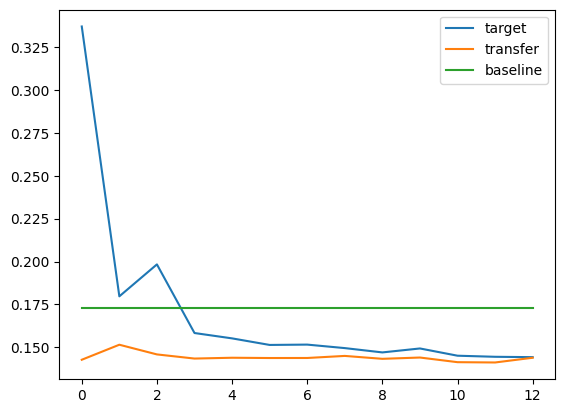

In [31]:
plt.plot(target_RMSEs,label='target')
plt.plot(transfer_RMSEs,label='transfer')
plt.plot(baseline_RMSEs, label='baseline')
plt.legend()

In [32]:
column_names = []

for i in range(len(training_months)+1):
    column_names.append(str(i) + 'm')

In [33]:
all_metrics = pd.DataFrame([baseline_RMSEs, target_RMSEs, transfer_RMSEs,
                            baseline_MBEs, target_MBEs, transfer_MBEs,
                            baseline_MAEs, target_MAEs, transfer_MAEs, 
                            target_best_epochs, transfer_best_epochs],
                           columns=column_names, index=['Baseline RMSE', 'Target RMSE', 'Transfer RMSE', 
                                                        'Baseline MBE', 'Target MBE', 'Transfer MBE', 
                                                        'Baseline MAE', 'Target MAE', 'Transfer MAE', 
                                                        'Target epoch', 'Transfer epoch']).transpose()

all_metrics['Target epoch'] = all_metrics['Target epoch'].astype(int)
all_metrics['Transfer epoch'] = all_metrics['Transfer epoch'].astype(int)
all_metrics

,Baseline RMSE,Target RMSE,Transfer RMSE,Baseline MBE,Target MBE,Transfer MBE,Baseline MAE,Target MAE,Transfer MAE,Target epoch,Transfer epoch
0m,0.173,0.337,0.143,-0.000,0.176,-0.005,0.077,0.195,0.079,0,0
1m,0.173,0.180,0.152,-0.000,0.069,0.035,0.077,0.098,0.081,28,129
2m,0.173,0.198,0.146,-0.000,0.006,0.026,0.077,0.100,0.078,123,187
3m,0.173,0.158,0.143,-0.000,0.023,0.017,0.077,0.082,0.075,19,173
4m,0.173,0.155,0.144,-0.000,0.042,0.023,0.077,0.084,0.077,137,47
5m,0.173,0.151,0.144,-0.000,0.017,0.013,0.077,0.084,0.078,5,25
6m,0.173,0.152,0.144,-0.000,0.020,0.012,0.077,0.084,0.078,188,31
7m,0.173,0.150,0.145,-0.000,0.021,0.017,0.077,0.082,0.079,198,21
8m,0.173,0.147,0.143,-0.000,0.021,0.015,0.077,0.080,0.077,184,19
9m,0.173,0.149,0.144,-0.000,0.019,0.013,0.077,0.083,0.079,197,18


In [34]:
all_metrics.to_csv('../results/AUS/' + 'summary_table_' + data_name + '.csv')

In [35]:
data_name

'base_australia_1'